In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import datetime as dt
import math
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

import helper
from helper import *

In [3]:
df = load_and_preprocess()
df = df.reset_index(drop = True)

In [4]:
cutoff = math.floor(0.75*len(df)) #train/test cutoff

#### Just Using Date/Previous Hour Temp.

In [ ]:
df.head()

In [ ]:
train = df[:cutoff].reset_index(drop = True)
train = train.iloc[:, 4:5].values
test = df[cutoff:]
test = test.iloc[:, 4:5].values

In [ ]:
sc = StandardScaler()
train_std = sc.fit_transform(train)
test_std = sc.transform(test)

In [5]:
def split(sequence, n_timestamp):
    X, y = [], []
    
    for i in range(len(sequence)):
        end = i + n_timestamp
        if end > len(sequence)-1:
            break
        sequence_x, sequence_y = sequence[i:end], sequence[end]
        X.append(sequence_x)
        y.append(sequence_y)
    return np.array(X), np.array(y)

In [ ]:
X_train, y_train = split(sequence = train_std, n_timestamp = 10)
X_test, y_test = split(sequence = test_std, n_timestamp = 10)

In [ ]:
print(X_train.shape)
print(X_test.shape)

In [ ]:
print(y_train.shape)
print(y_test.shape)

In [ ]:
model = keras.models.Sequential()

model.add(keras.layers.LSTM(units = 50, return_sequences = True, input_shape = X_train.shape[1:]))
model.add(keras.layers.LSTM(units = 50))
model.add(keras.layers.Dense(1))

In [ ]:
model.compile(loss = 'mse', optimizer = 'adam')

In [ ]:
history = model.fit(X_train, y_train, epochs = 3)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_test_inv = sc.inverse_transform(y_test)
y_pred_inv = sc.inverse_transform(y_pred)

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize = (20, 10))
plt.plot(y_test_inv, label = 'Actual')
plt.plot(y_pred_inv, label = 'Predicted')
plt.ylabel('Temperature')
plt.xlabel('Day')
plt.xlim([0, 365])
plt.ylim([278, 305])
plt.legend()
plt.show()

In [ ]:
print('MSE:', mean_squared_error(y_test_inv, y_pred_inv))
print('R-Squared:', r2_score(y_test_inv, y_pred_inv))

In [ ]:
math.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

#### Trying with multiple predictors

In [6]:
def split_multiple(sequence, n_timestamp, target):
    X, y = [], []
    
    for i in range(len(sequence)):
        end = i + n_timestamp
        if end > len(sequence)-1:
            break
        sequence_x, sequence_y = sequence[i:end], target[end]
        X.append(sequence_x)
        y.append(sequence_y)
    return np.array(X), np.array(y)

In [ ]:
train = df[:cutoff].reset_index(drop = True)
target_train = train[['Temperature']].values
train = train.drop(['datetime', 'Description'], axis = 1).values

test = df[:cutoff].reset_index(drop = True)
target_test = test[['Temperature']].values
test = test.drop(['datetime', 'Description'], axis = 1).values

In [ ]:
sc = StandardScaler()
sc2 = StandardScaler()
train_std = sc.fit_transform(train)
target_train_std = sc2.fit_transform(target_train)
test_std = sc.transform(test)
target_test_std = sc2.transform(target_test)

In [ ]:
X_train, y_train = split_multiple(train_std, 10, target_train_std)

In [ ]:
X_train.shape

In [ ]:
y_train.shape

In [ ]:
model = keras.models.Sequential()

model.add(keras.layers.LSTM(units = 50, return_sequences = True, input_shape = X_train.shape[1:]))
model.add(keras.layers.LSTM(units = 50))
model.add(keras.layers.Dense(1))

In [ ]:
model.compile(loss = 'mse', optimizer = 'adam')

In [ ]:
history = model.fit(X_train, y_train, epochs = 3)

In [ ]:
X_test, y_test = split_multiple(test_std, 10, target_test_std)

In [ ]:
y_pred = model.predict(X_test)

y_test_inv = sc2.inverse_transform(y_test)
y_pred_inv = sc2.inverse_transform(y_pred)

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize = (20, 10))
plt.plot(y_test_inv, label = 'Actual')
plt.plot(y_pred_inv, label = 'Predicted')
plt.ylabel('Temperature')
plt.xlabel('Day')
plt.xlim([0, 365])
plt.ylim([270, 295])
plt.legend()
plt.show()

In [ ]:
print('MSE:', mean_squared_error(y_test_inv, y_pred_inv))
print('R-Squared:', r2_score(y_test_inv, y_pred_inv))

In [ ]:
math.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

### Incorporating Engineered Features

In [7]:
df = feature_engineer_important(load_and_preprocess())

/Users/jakehogan/Desktop/MMA Courses/INSY 695/Assignments/Group Project/Cloud-Computations/helper.py:136: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['week'] = df['datetime'].dt.weekofyear


In [8]:
df.iloc[167:170, ] #looks like due to the shifts we should drop the first week of observations (which is fine)

,Humidity,Wind Direction,Pressure,hour,week,max daily temp,min daily temp,min daily hum,min weekly temp,mean daily temp,mean daily pressure,mean weekly temp,rolling_mean_temp,rolling_mean_pressure,rolling_mean_wind_speed,Temperature
datetime,,,,,,,,,,,,,,,,
2012-10-08 12:00:00,71.861538,1016.424953,317.0,12,41,291.46,282.16,286.07,NaN,291.46,310.0,NaN,286.704215,195.875000,1.839286,278.39
2012-10-08 13:00:00,71.861538,1016.424953,282.0,13,41,291.46,282.16,286.07,282.16,291.46,310.0,287.209794,286.656439,196.384615,1.828402,278.63
2012-10-08 14:00:00,71.861538,1016.424953,288.0,14,41,291.46,282.16,286.07,282.16,291.46,310.0,287.209794,286.614754,196.923529,1.817647,279.57


In [9]:
df = df.dropna()

#### RNN with New Features

In [10]:
train = df[:cutoff].reset_index(drop = True)
target_train = train[['Temperature']].values
train = train.values

test = df[:cutoff].reset_index(drop = True)
target_test = test[['Temperature']].values
test = test.values

In [11]:
sc = StandardScaler()
sc2 = StandardScaler()
train_std = sc.fit_transform(train)
target_train_std = sc2.fit_transform(target_train)
test_std = sc.transform(test)
target_test_std = sc2.transform(target_test)

In [12]:
X_train, y_train = split_multiple(train_std, 10, target_train_std)

In [13]:
X_train.shape

(33929, 10, 16)

In [14]:
model = keras.models.Sequential()

model.add(keras.layers.LSTM(units = 50, return_sequences = True, input_shape = X_train.shape[1:]))
model.add(keras.layers.LSTM(units = 50))
model.add(keras.layers.Dense(1))

model.compile(optimizer='adam', loss='mse')

In [15]:
history = model.fit(X_train, y_train, epochs=3)

Train on 33929 samples
Epoch 1/3
33929/33929 [==============================] - 40s 1ms/sample - loss: 0.0386
Epoch 2/3
33929/33929 [==============================] - 37s 1ms/sample - loss: 0.0108
Epoch 3/3
33929/33929 [==============================] - 36s 1ms/sample - loss: 0.0090


In [16]:
X_test, y_test = split_multiple(test_std, 10, target_test_std)

In [17]:
y_pred = model.predict(X_test)

y_pred_inv = sc2.inverse_transform(y_pred)
y_test_inv = sc2.inverse_transform(y_test)

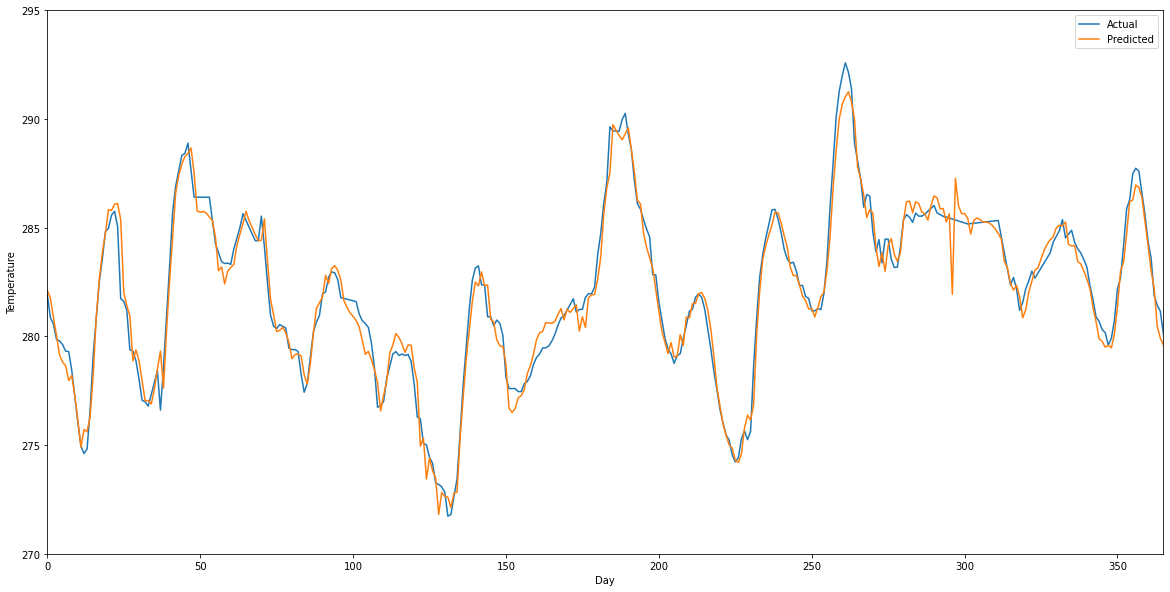

In [19]:
from matplotlib import pyplot as plt
plt.figure(figsize = (20, 10))
plt.plot(y_test_inv, label = 'Actual')
plt.plot(y_pred_inv, label = 'Predicted')
plt.ylabel('Temperature')
plt.xlabel('Day')
plt.xlim([0, 365])
plt.ylim([270, 295])
plt.legend()
plt.show()

In [20]:
print('MSE:', mean_squared_error(y_test_inv, y_pred_inv))
print('R-Squared:', r2_score(y_test_inv, y_pred_inv))
print('RMSE:', math.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))

MSE: 1.2513190733748163
R-Squared: 0.9916856969034261
RMSE: 1.1186237407523658
